### Step 1: Construct the assays & compounds table

#### 1.1 Construct the assays table,with fields as the following

CID VARCHAR(30) PRIMARY KEY,  
r_inhibition_at_20_uM DOUBLE,  
r_inhibition_at_50_uM DOUBLE,  
r_avg_IC50 DOUBLE,  
f_inhibition_at_20_uM DOUBLE,  
f_inhibition_at_50_uM DOUBLE,  
f_avg_IC50 DOUBLE,  
f_avg_pIC50 DOUBLE  


In [1]:
import sqlite3 as sql
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from rdkit.ML.Cluster.Butina import ClusterData
import csv
from pathlib import Path

In [2]:
#file names of databases
data_file = Path('activity_data.csv')
db_file = Path('MPro_binding.db')

In [3]:
# # 1: drop the database
# for table_name in ('compounds','assays'):
#     sql.connect(db_file).execute('DROP TABLE IF EXISTS ' + table_name)

In [4]:
# # 2: create a new database
# conn = sql.connect(db_file)
# conn.execute('''
# CREATE TABLE assays
# (
#     CID VARCHAR(20) PRIMARY KEY,
#     r_inhibition_at_20_uM DECIMAL,
#     r_inhibition_at_50_uM DECIMAL,
#     r_avg_IC50 DECIMAL,
#     f_inhibition_at_20_uM DECIMAL,
#     f_inhibition_at_50_uM DECIMAL,
#     f_avg_IC50 DECIMAL,
#     f_avg_pIC50 DECIMAL
# )

# ''')

# conn.execute('''
# CREATE TABLE compounds
# (
#     CID VARCHAR(20) PRIMARY KEY,
#     SMILES VARCHAR(2000) NOT NULL,
#     FOREIGN KEY(CID) REFERENCES assays(CID) 
# )
# ''')


In [5]:
# # 3: Add records to the table assays 
# itemlist = []
# with open(data_file,encoding="utf8") as csvfile:
#     reader = csv.DictReader(csvfile,delimiter=',')
#     for row in reader:
#         itemlist.append((row['CID'],row['r_inhibition_at_20_uM'],
#                          row['r_inhibition_at_50_uM'],row['r_avg_IC50'],
#                          row['f_inhibition_at_20_uM'],row['f_inhibition_at_50_uM'],
#                          row['f_avg_IC50'],row['f_avg_pIC50']))
# print(itemlist)
# conn = self.get_conn()
# conn.executemany('INSERT INTO <TABLE> (Col1, Col2) VALUES(?,?)', ((1,2), (2,3)))
# print('###############################')
        
# # 4: Add records to the table compounds
# itemlist = []
# with open(data_file, newline='',encoding="utf8") as csvfile:
#     reader = csv.DictReader(csvfile)
#     for row in reader:
#         print(type(row['CID']))
#         print(type(row['SMILES']))
#         itemlist.append((row['CID'],row['SMILES']))

# #print(itemlist)
# conn = sql.connect(db_file)
# conn.executemany("INSERT INTO compounds (CID,SMILES) VALUES(?,?)",itemlist)
                
                

In [6]:
# # 5. check whether records have been inserted successfully (show the table)
# '''
# for table in ('assays','compounds'):
#     cur = sql.connect(db_file).execute('SELECT sql FROM sqlite_master WHERE name=\'' + table + '\'')
#     row = cur.fetchall()
#     if row is not None:
#         print(table+'\n')
#         print(row[0:5])
#     else:
#         print('Table ' + table + ' not found')
# '''
# conn = sql.connect(db_file)
# result = conn.execute('''
#     SELECT
#         SMILES
#     FROM 
#         compounds''')
# print(result)
# for row in result:
#     print(row)


### We give up sql, and we used pandas instead

In [7]:
#Create assays and compounds tabel from the activity data.
df_temp = pd.read_csv(data_file)
assays = df_temp[['CID','r_inhibition_at_20_uM','r_inhibition_at_50_uM','r_avg_IC50','f_inhibition_at_20_uM','f_inhibition_at_50_uM','f_avg_IC50','f_avg_pIC50']]
compounds = df_temp[['CID','SMILES']]

In [8]:
assays.head()

,CID,r_inhibition_at_20_uM,r_inhibition_at_50_uM,r_avg_IC50,f_inhibition_at_20_uM,f_inhibition_at_50_uM,f_avg_IC50,f_avg_pIC50
0,LUO-POS-e1dab717-11,NaN,NaN,NaN,NaN,NaN,0.275118,NaN
1,LUO-POS-e1dab717-12,NaN,NaN,NaN,NaN,NaN,0.202767,NaN
2,MAT-POS-e48723dc-1,NaN,NaN,NaN,NaN,NaN,55.453947,NaN
3,MAT-POS-e48723dc-2,NaN,NaN,NaN,NaN,NaN,0.050000,NaN
4,LUO-POS-9931618f-2,NaN,NaN,NaN,NaN,NaN,0.052757,NaN


In [9]:
compounds.head()

,CID,SMILES
0,LUO-POS-e1dab717-11,CCNC(=O)CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl...
1,LUO-POS-e1dab717-12,O=C(CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl)ccc...
2,MAT-POS-e48723dc-1,CNC(=O)C1(N2C[C@]3(CCN(c4cncc5ccccc45)C3=O)c3c...
3,MAT-POS-e48723dc-2,CNC(=O)C1(N2C[C@@]3(CCN(c4cncc5ccccc45)C3=O)c3...
4,LUO-POS-9931618f-2,CNC(=O)CN1C[C@@]2(CCN(c3cncc4ccccc34)C2=O)c2cc...


### Step 2: data exploration 

#### 2.1: Molecular descriptors

In [10]:
#%pip install rdkit

In [11]:
import rdkit.Chem as Chem
from rdkit.Chem.Descriptors import MolWt, MolLogP, NumHDonors, NumHAcceptors

In [12]:
def calculate_descriptors(smile):
    '''
    Function to calculate the molecular descriptors for Lipinski's rule of five.
    
    Parameters
    ----------
    smile: SMILES string
        Representation of chemical molecule structure
    '''
    
    molecule = Chem.MolFromSmiles(smile)
    if molecule:
        hbd, hba, mw, logpow = [x(molecule) for x in [NumHDonors, NumHAcceptors, MolWt, MolLogP]]
        res = [hbd, hba, mw, logpow]
    else:
        res = [None] * 4
    return res

In [13]:
# Add molecular descriptors to compounds table
hbd, hba, mw, logpow =[],[],[],[]
for i in range(len(compounds)):
    hbd_temp, hba_temp, mw_temp, pow_temp = calculate_descriptors(compounds['SMILES'][i])
    hbd.append(hbd_temp)
    hba.append(hba_temp)
    mw.append(mw_temp)
    logpow.append(pow_temp)
compounds['hbd'] = hbd
compounds['hba'] = hba
compounds['mw'] = mw
compounds['pow'] = logpow

C:\Users\Swimming\AppData\Local\Temp\ipykernel_24316\2634574420.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compounds['hbd'] = hbd
C:\Users\Swimming\AppData\Local\Temp\ipykernel_24316\2634574420.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compounds['hba'] = hba
C:\Users\Swimming\AppData\Local\Temp\ipykernel_24316\2634574420.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

Lipinski's rule of five criteria: 
* 5 or fewer hydrogen bond donors;
* 10 or fewer hydrogen bond acceptors;
* A molecular weight (MW) of less than 500 Daltons;
* An octanol-water partition coefficient (log Po/w) of less than 5. Larger log Po/w means more lipophilic (i.e., less water soluble).

In [14]:
# Select compounds based on Lipinski's rule of five
print('Total number of compounds: ',len(compounds))
compounds_lip_strict = compounds.loc[(compounds['hbd']<=5) & (compounds['hba']<=10) & (compounds['mw']<500) & (compounds['pow']<5)]
print('Number of compounds after selected by Lipinski rule: ',len(compounds_lip_strict))
assays_lip_strict = assays.loc[(compounds['hbd']<=5) & (compounds['hba']<=10) & (compounds['mw']<500) & (compounds['pow']<5)]
print('Number of assays after Lipinski rule: ',len(assays_lip_strict))

Total number of compounds:  2062
Number of compounds after selected by Lipinski rule:  1539
Number of assays after Lipinski rule:  1539


In [15]:
#NOTE: need to update the figures to ggplot, add xy-labels etc

In [16]:
%matplotlib inline
def plot_hist(data_1,data_2,nbins=100):
    data_1 = data_1.to_numpy()
    data_2 = data_2.to_numpy()
    plt.hist(data_1[~np.isnan(data_1)],bins=nbins,alpha=0.3,density=True)
    plt.hist(data_2[~np.isnan(data_2)],bins=nbins,alpha=0.3,density=True)

198.0


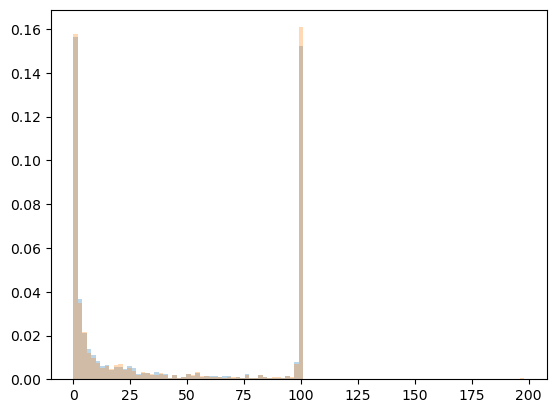

In [17]:
print(max(assays['f_avg_IC50']))
plot_hist(assays['f_avg_IC50'],assays_lip_strict['f_avg_IC50'])

In [18]:
# Select compounds based on meeting at least 3 of the Lipinski's rule of five citeria
compounds_lip = compounds[(compounds['hbd']<=5).astype(int) + (compounds['hba']<=10).astype(int) + (compounds['mw']<500).astype(int) + (compounds['pow']<5).astype(int)>=3]
assays_lip = assays[(compounds['hbd']<=5).astype(int) + (compounds['hba']<=10).astype(int) + (compounds['mw']<500).astype(int) + (compounds['pow']<5).astype(int)>=3]
print('Number of compounds after less strict lipinski rule: ',len(compounds_lip))

Number of compounds after less strict lipinski rule:  1974


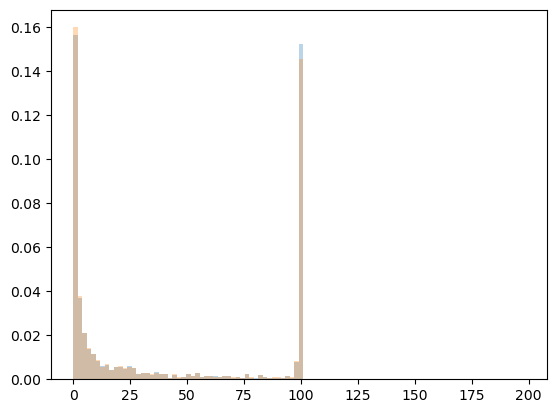

In [19]:
plot_hist(assays['f_avg_IC50'],assays_lip['f_avg_IC50'])

By filtering the compounds in a less strict way, we definitely obtained more compounds!


#### 2.2 ECFP fingerprints

In [20]:
# Check whether we have revised the compounds
len(compounds)

2062

In [21]:
from rdkit.Chem import AllChem
from rdkit.DataStructs import FingerprintSimilarity,DiceSimilarity

In [22]:
def ECFP(smile,radius=2,nBits=2048):
    '''
    Function to determine the ECFP (Morgan) fingerprints.
    
    Parameters
    ----------
    smile: SMILES string
        Representation of chemical molecule structure
    radius: integer
        Measure of the 'local' information captured by the fingerprint
    nBits = integer
        length of the fingerprint
    '''
    
    molecule = Chem.MolFromSmiles(smile)
    return AllChem.GetMorganFingerprintAsBitVect(molecule,radius,nBits=nBits)

In [23]:
# Add ECFP to the compounds table 
ECFP_temp = []
for i in range(len(compounds)):
    ECFP_temp.append(ECFP(compounds['SMILES'][i]))
compounds['ECFP'] = ECFP_temp

C:\Users\Swimming\AppData\Local\Temp\ipykernel_24316\2033161879.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compounds['ECFP'] = ECFP_temp


In [24]:
compounds.head()

,CID,SMILES,hbd,hba,mw,pow,ECFP
0,LUO-POS-e1dab717-11,CCNC(=O)CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl...,1,5,498.992,2.7033,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,LUO-POS-e1dab717-12,O=C(CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl)ccc...,1,5,525.030,3.0934,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,MAT-POS-e48723dc-1,CNC(=O)C1(N2C[C@]3(CCN(c4cncc5ccccc45)C3=O)c3c...,1,4,474.948,3.2973,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,MAT-POS-e48723dc-2,CNC(=O)C1(N2C[C@@]3(CCN(c4cncc5ccccc45)C3=O)c3...,1,4,474.948,3.2973,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,LUO-POS-9931618f-2,CNC(=O)CN1C[C@@]2(CCN(c3cncc4ccccc34)C2=O)c2cc...,1,4,448.910,2.7647,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [25]:
def compute_similarity(fingerprint_1,fingerprint_2):
    '''
    Function to compute the Tanimoto (a.k.a. Jaccard) index between two fingerprints
    
    Parameters
    ----------
    fingerprint_1: 
        Bit vector representing a chemical molecular structure
    fingerprint_2: 
        Bit vector representing a chemical molecular structure
    '''
    
    return FingerprintSimilarity(fingerprint_1,fingerprint_2, metric=DiceSimilarity)

In [26]:
# Construct similarity matrix of the Tanimoto index values
similarity_matrix = np.zeros((len(compounds),len(compounds)))
for i in range(len(compounds)):
    for j in range(len(compounds)):
        similarity_matrix[i,j] = compute_similarity(compounds['ECFP'][i],compounds['ECFP'][j])

<AxesSubplot:>

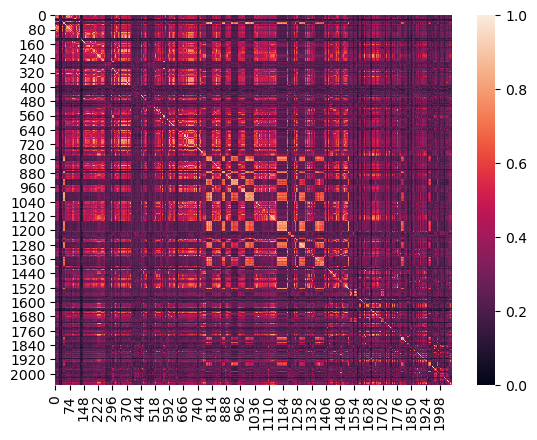

In [27]:
# Create a heatmap of the similarity matrix
seaborn.heatmap(similarity_matrix)

C:\Users\Swimming\anaconda3\lib\site-packages\seaborn\matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


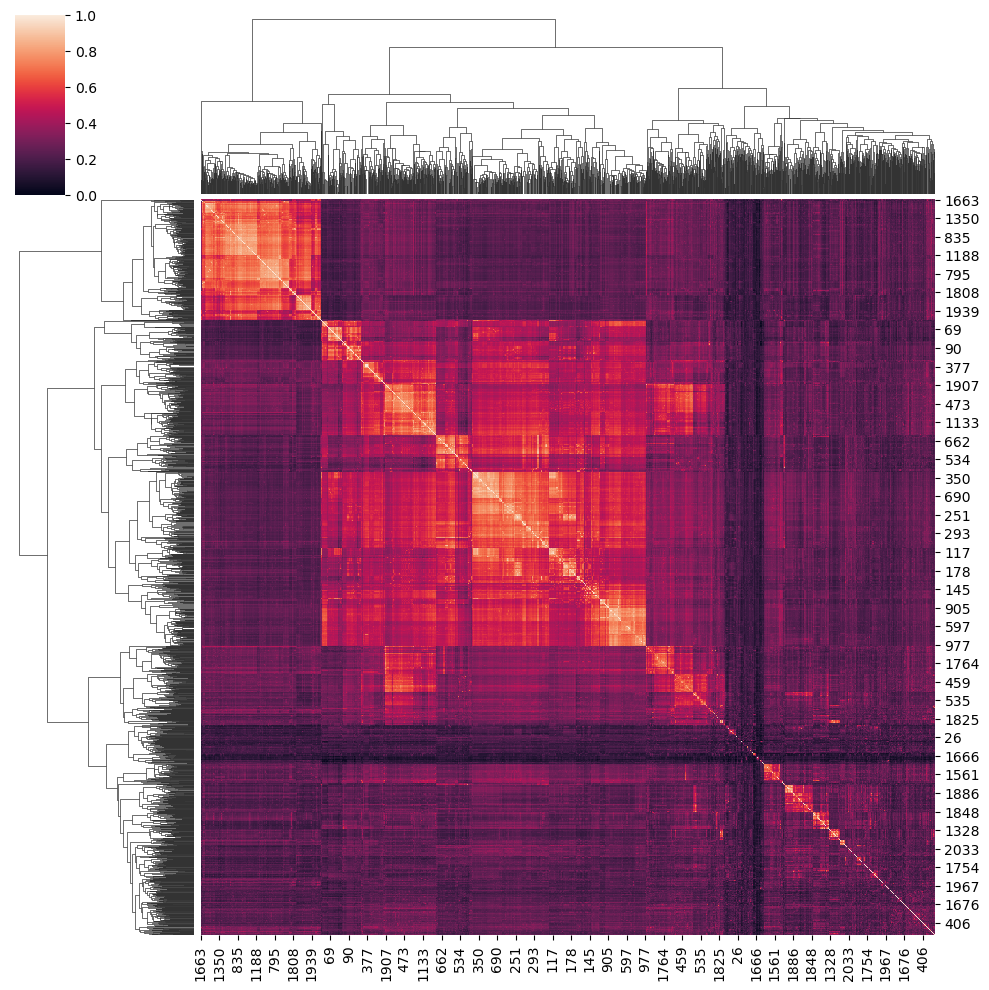

In [28]:
# Add clusters to heatmap
seaborn.clustermap(similarity_matrix)

In [29]:
# determine the indices with the higest similarity score
from rdkit.Chem import Draw
from collections import Counter

#Determine the highest similarity score
dict_occurence_similarityscore = Counter(similarity_matrix.flatten())
sorted_dict_occurence_ss = dict(sorted(dict_occurence_similarityscore.items()))
for x in list(sorted_dict_occurence_ss)[-2:-1]:
    print('{}: {}'.format(x, sorted_dict_occurence_ss[x]))
    highest_score = x

#determine the indices with the highest similarity score
i, j = np.where(np.isclose(similarity_matrix, highest_score))
print('Index of highest similarity score: x: {}, y: {}'.format(i[0], j[0]))

0.9855072463768116: 2
Index of highest similarity score: x: 346, y: 698


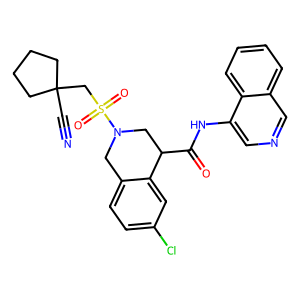

In [30]:
#draw the structures
m1 = Chem.MolFromSmiles(compounds['SMILES'][i[0]])
Draw.MolToImage(m1)

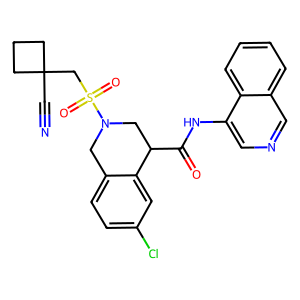

In [31]:
m2 = Chem.MolFromSmiles(compounds['SMILES'][j[0]])
Draw.MolToImage(m2)

In [32]:
# Study Murcko Scaffolds
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold

In [33]:
def generate_murcko_scaffolds(smile):
    '''
    Function to determine the murcko scaffold
    
    Parameters
    ----------
    smile: SMILES string
        Representation of chemical molecule structure
    '''
    
    m = Chem.MolFromSmiles(smile)
    return Chem.MolToSmiles(Chem.Scaffolds.MurckoScaffold.GetScaffoldForMol(m))

In [34]:
# Store the Murcko scaffolds 
compounds_scaffold = compounds.copy()
mscaffold_temp = []
for i in range(len(compounds_scaffold)):
    mscaffold_temp.append(generate_murcko_scaffolds(compounds_scaffold['SMILES'][i]))
compounds_scaffold['murcko'] = mscaffold_temp

In [35]:
# Determine occurence of every Murcko scaffold
compounds_scaffold['murcko'].value_counts()

O=C(Cc1ccccc1)Nc1cncc2ccccc12                                    98
O=C(Nc1cncc2ccccc12)C1CCOc2ccccc21                               81
O=C(Nc1cncc2ccccc12)C1CNCc2ccccc21                               48
O=C1NCC(C(=O)Nc2cncc3ccccc23)c2ccccc21                           43
O=C(Cc1ccccc1)Nc1cccnc1                                          33
                                                                 ..
O=C(C(c1cccnc1)N(C(=O)c1cocn1)c1ccccc1)N1CCC(c2ccccc2)CC1         1
O=C(NCCc1ccccc1)C(c1cccnc1)N(C(=O)c1cocn1)c1ccc(-n2ccnn2)cc1      1
O=C(NCCc1ccccc1)C(c1cccnc1)N(C(=O)c1ccon1)c1ccccc1                1
O=C(NCCc1ccccc1)C(c1cccnc1)N(C(=O)c1cocn1)c1ccc(N2CCCC2=O)cc1     1
O=C(Nc1ccccc1)Nc1c[nH]c2ncccc12                                   1
Name: murcko, Length: 1179, dtype: int64

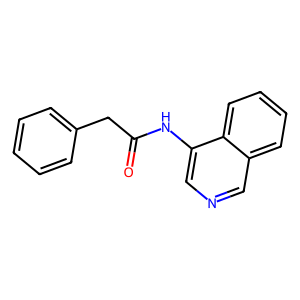

In [36]:
# Draw the structure of the most occuring Murcko scaffold
m = Chem.MolFromSmiles('O=C(Cc1ccccc1)Nc1cncc2ccccc12')
Draw.MolToImage(m)

(array([  32158.,  695284., 1905256.,  692900.,  397898.,  293802.,
         140340.,   66962.,   23230.,    4014.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

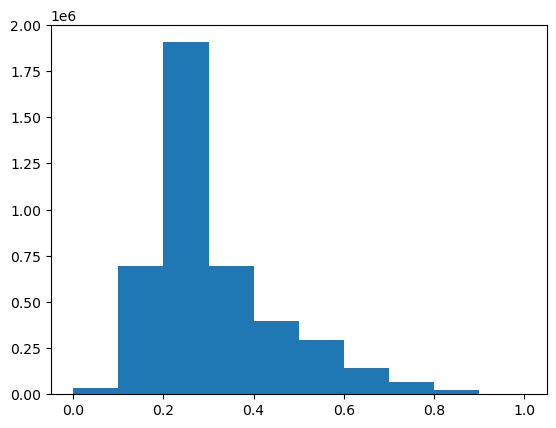

In [37]:
plt.hist(similarity_matrix.flatten())

In [38]:
cluster_result = DBSCAN(eps=0.2,min_samples=30,metric='precomputed').fit(1 - similarity_matrix)

(array([1279.,  284.,   34.,  219.,  193.]),
 array([-1,  0,  1,  2,  3,  4], dtype=int64),
 <BarContainer object of 5 artists>)

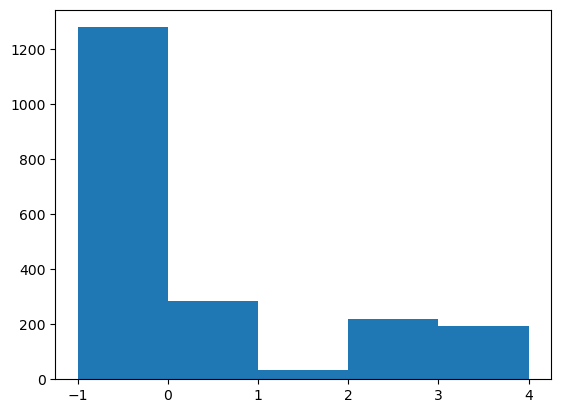

In [39]:
plt.hist(cluster_result.labels_,np.arange(np.min(cluster_result.labels_),np.max(cluster_result.labels_)),histtype='bar')

In [40]:
# We now leave the clustering
result = ClusterData(1 - similarity_matrix.flatten(),nPts=3,distThresh=0.5, isDistData=True) 

[11:15:57] WARNING: Distance matrix is too long



In [95]:
# Compute pIC50:
assays['r_avg_pIC50'] = - np.log10(assays['r_avg_IC50']) + 6
assays['f_avg_pIC50'] = - np.log10(assays['f_avg_IC50']) + 6

C:\Users\Swimming\AppData\Local\Temp\ipykernel_24316\994153225.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assays['r_avg_pIC50'] = - np.log10(assays['r_avg_IC50']) + 6
C:\Users\Swimming\AppData\Local\Temp\ipykernel_24316\994153225.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assays['f_avg_pIC50'] = - np.log10(assays['f_avg_IC50']) + 6


(array([  1.,   0.,   0.,   0.,   0.,   0., 623.,  18.,  17.,  18.,  16.,
         22.,  16.,  13.,  21.,  22.,  18.,  19.,  35.,  22.,  29.,  13.,
         19.,  19.,  19.,  23.,  11.,  23.,  24.,  19.,  23.,  18.,  27.,
         20.,  22.,  25.,  23.,  23.,  22.,  20.,  22.,  28.,  22.,  21.,
         16.,  20.,  24.,  19.,  22.,  24.,  20.,  19.,  23.,  13.,  21.,
         19.,  17.,  17.,  27.,  25.,  27.,  17.,  12.,  24.,  14.,  12.,
         22.,  16.,  10.,   8.,   9.,   7.,   4.,  12.,   2.,   3.,   1.,
          0.,   0.,   1.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([3.70333481, 3.75203966, 3.80074451, 3.84944935, 3.8981542 ,
        3.94685905, 3.9955639 , 4.04426875, 4.0929736 , 4.14167845,
        4.19038329, 4.23908814, 4.28779299, 4.33649784, 4.38520269,
        4.43390754, 4.48261238, 4.53131723, 4.58002208, 4.62872693,
        4.67743178, 4.72613663, 4.77484147, 4.

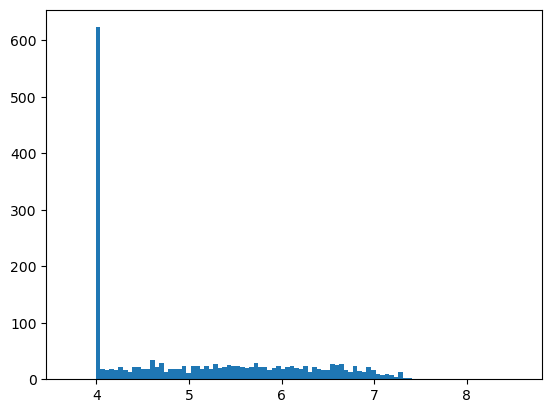

In [96]:
plt.hist(assays['f_avg_pIC50'],bins=100)


1926


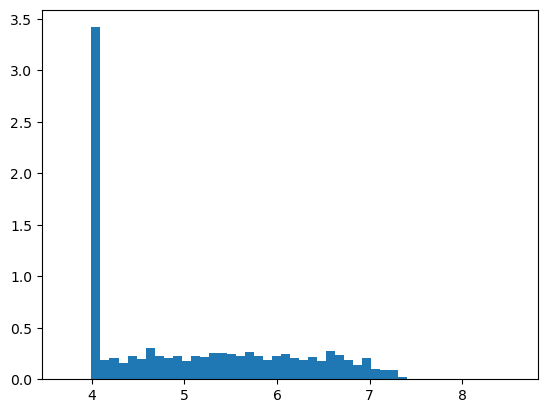

In [97]:
import math
plt.hist(assays[assays['f_avg_pIC50']>=-math.log(99,10)]['f_avg_pIC50'],bins=50,density=True)
print(np.sum(assays['f_avg_pIC50']>-1.9))

663


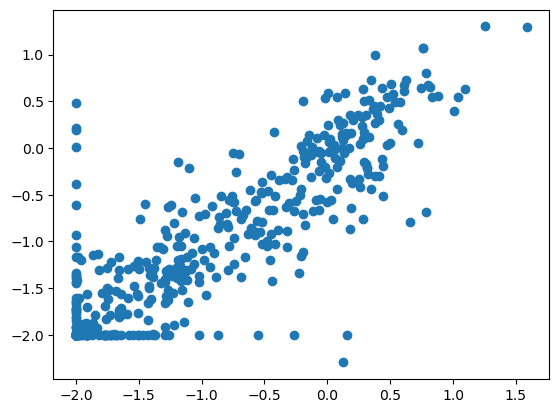

In [44]:
print(np.sum(~np.isnan(assays['r_avg_pIC50'])))
plt.scatter(assays['r_avg_pIC50'],assays['f_avg_pIC50'])

Now we need to compute how many compounds have r_avg_pIC50,f_avg_pIC50, and how many compounds have both of them.

In [56]:
print('Total number of compounds: ',np.sum(len(assays)))
print('Number of compounds have f_avg_pIC50: ',np.sum(~np.isnan(assays['f_avg_pIC50'])))
print('Number of compounds have r_avg_pIC50: ',np.sum(~np.isnan(assays['r_avg_pIC50'])))
print('Number of compounds have both f_avg_pIC50 and r_avg_pIC50: ',np.sum((~np.isnan(assays['r_avg_pIC50'])) & (~np.isnan(assays['f_avg_pIC50']))))
print('Number of compounds have one of f_avg_pIC50 and r_avg_pIC50: ',np.sum((~np.isnan(assays['r_avg_pIC50'])) | (~np.isnan(assays['f_avg_pIC50']))))

Total number of compounds:  2062
Number of compounds have f_avg_pIC50:  1926
Number of compounds have r_avg_pIC50:  663
Number of compounds have both f_avg_pIC50 and r_avg_pIC50:  528
Number of compounds have one of f_avg_pIC50 and r_avg_pIC50:  2061


In [52]:
index_of_compound_two_labels = (~np.isnan(assays['r_avg_pIC50'])) & (~np.isnan(assays['f_avg_pIC50']))

Text(0, 0.5, 'f_avg_pIC50')

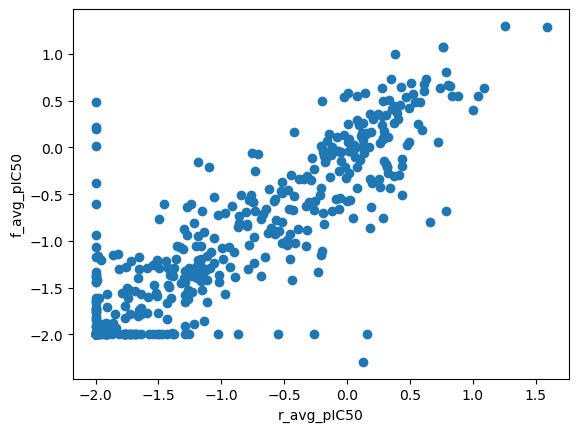

In [55]:
plt.scatter(assays[index_of_compound_two_labels]['r_avg_pIC50'],assays[index_of_compound_two_labels]['f_avg_pIC50'])
plt.xlabel('r_avg_pIC50')
plt.ylabel('f_avg_pIC50')

#### For the rest of the day
* plot distribution of pIC50(f&r), plot their correlations.(finished）
* Can we expand the dataset with chembl data?
* explore how to do the clustering based on similarity score (we used DBSCAN, and got 4 clusters). But the real challenge is how we interpretate the results(whether some scaffolds are overrepresented) 
* ML issues: training data, validation set, and test data.

#### Start of DAY3

There are at least two issues here:
 * Are some scaffolds over-represented, and do you think this will pose a challenge when using these data to develop a model to predict Mpro binding affinity for a novel compound?
 * How do we deal with the distribution of $pIC_{50}$. Should we start from classification task?
 We might start from the simple case. (randomly split the data samples)

Ideas to explore:
(1) undersample over-represented data and oversample under-represented data
(2) split the training and test set (maybe validation set). It depends on whether we need to fine-tune the parameters.
(3) Is it beneficial to split the data by ligand similarity?

> For the rest part of this project, we will focus only on the compounds having f_avg_pIC50 (1926/2062)

In [99]:
whole_data_set = pd.DataFrame({'CID':assays['CID'],
                               'SMILES':compounds['SMILES'],
                               'f_avg_pIC50':assays['f_avg_pIC50'],
                               'hbd':compounds['hbd'],
                               'hba':compounds['hba'],
                               'mv':compounds['mw'],
                               'pow':compounds['pow'],
                               'ECFP':compounds['ECFP']})


In [128]:
from rdkit.Chem import Descriptors
# Helper function to compute descriptors for a single molecule
def compute_descriptors(smile):
    molecule = Chem.MolFromSmiles(smile)
    descriptors = {d[0]: d[1](molecule) for d in Descriptors.descList}
    descriptors = pd.Series(descriptors)
    return descriptors


In [131]:
all_descriptors = []
for i in range(len(whole_data_set)):
    temp_descriptors = compute_descriptors(whole_data_set['SMILES'][i])
    all_descriptors.append(temp_descriptors.to_numpy())
    
all_descriptors = np.array(all_descriptors).T

In [135]:
index = 0
for i,v in temp_descriptors.items():
    whole_data_set[i] = all_descriptors[index,:]
    index += 1

C:\Users\Swimming\AppData\Local\Temp\ipykernel_24316\1582121756.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  whole_data_set[i] = all_descriptors[index,:]
C:\Users\Swimming\AppData\Local\Temp\ipykernel_24316\1582121756.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  whole_data_set[i] = all_descriptors[index,:]
C:\Users\Swimming\AppData\Local\Temp\ipykernel_24316\1582121756.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performan

In [140]:
whole_data_set.head()

,CID,SMILES,f_avg_pIC50,hbd,hba,mv,pow,ECFP,MaxEStateIndex,MinEStateIndex,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,LUO-POS-e1dab717-11,CCNC(=O)CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl...,6.560481,1,5,498.992,2.7033,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",14.101608,-3.985876,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,LUO-POS-e1dab717-12,O=C(CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl)ccc...,6.693003,1,5,525.030,3.0934,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",14.199184,-3.990499,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,MAT-POS-e48723dc-1,CNC(=O)C1(N2C[C@]3(CCN(c4cncc5ccccc45)C3=O)c3c...,4.256068,1,4,474.948,3.2973,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",14.256036,-0.977480,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,MAT-POS-e48723dc-2,CNC(=O)C1(N2C[C@@]3(CCN(c4cncc5ccccc45)C3=O)c3...,7.301030,1,4,474.948,3.2973,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",14.256036,-0.977480,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,LUO-POS-9931618f-2,CNC(=O)CN1C[C@@]2(CCN(c3cncc4ccccc34)C2=O)c2cc...,7.277723,1,4,448.910,2.7647,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",14.024602,-0.973105,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [141]:
len(whole_data_set)

2062

In [142]:
whole_data_set.shape

(2062, 216)

In [143]:
# Filter those that do not have f_avg_pIC50
df = whole_data_set[~np.isnan(whole_data_set['f_avg_pIC50'])]

In [144]:
len(df)

1926

In [145]:
df

,CID,SMILES,f_avg_pIC50,hbd,hba,mv,pow,ECFP,MaxEStateIndex,MinEStateIndex,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,LUO-POS-e1dab717-11,CCNC(=O)CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl...,6.560481,1,5,498.992,2.70330,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",14.101608,-3.985876,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,LUO-POS-e1dab717-12,O=C(CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl)ccc...,6.693003,1,5,525.030,3.09340,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",14.199184,-3.990499,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,MAT-POS-e48723dc-1,CNC(=O)C1(N2C[C@]3(CCN(c4cncc5ccccc45)C3=O)c3c...,4.256068,1,4,474.948,3.29730,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",14.256036,-0.977480,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,MAT-POS-e48723dc-2,CNC(=O)C1(N2C[C@@]3(CCN(c4cncc5ccccc45)C3=O)c3...,7.301030,1,4,474.948,3.29730,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",14.256036,-0.977480,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,LUO-POS-9931618f-2,CNC(=O)CN1C[C@@]2(CCN(c3cncc4ccccc34)C2=O)c2cc...,7.277723,1,4,448.910,2.76470,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",14.024602,-0.973105,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2057,WAR-XCH-eb7b662f-2,N#Cc1cc(Cl)cc(NC(=O)Nc2cccnc2)c1,4.004321,2,3,272.695,3.25068,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",11.716797,-0.431337,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2058,DAR-DIA-23aa0b97-8,N#Cc1cccc(NC(=O)Nc2cncc(N)c2)c1,4.265416,3,4,253.265,2.17948,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",11.719064,-0.428250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2059,DAR-DIA-23aa0b97-11,N#Cc1cccc(NC(=O)Nc2c[nH]c3ncccc23)c1,4.196851,3,3,277.287,3.07858,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",11.983708,-0.379775,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2060,DAR-DIA-23aa0b97-19,N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1,4.573171,1,3,287.322,3.28768,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",12.203380,-0.131257,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [146]:
# Save the df as preprocess_data, note: the ECFP object have not been processed! But that's okay
df.to_csv('preprocessed_data.csv')

#### Step 3.1: Randomly split the data(80/20), use multiple linear regression/ decision tree with 4 features to predict f_avg_pIC50

> Attention: We observed an over-represented compounds near $IC_{50}$ value $>=99$, so we filter all of them 

In [119]:
import math
df_filtered = df[df['f_avg_pIC50']>=(-math.log(98.999,10)+6)]

In [120]:
len(df_filtered)

1316

In [71]:
# Specify the random state
random_state = 42

In [121]:
from sklearn.model_selection import train_test_split
X = df_filtered[['hbd','hba','mv','pow']].to_numpy()
y = df_filtered['f_avg_pIC50'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [122]:
X_train.shape

(1052, 4)

Coefficients: 
 [-0.05996871 -0.20600212  0.00575377 -0.16354682]
Mean squared error: 0.73
Coefficient of determination: 0.10


Text(0, 0.5, 'Predicted Binding Affinity')

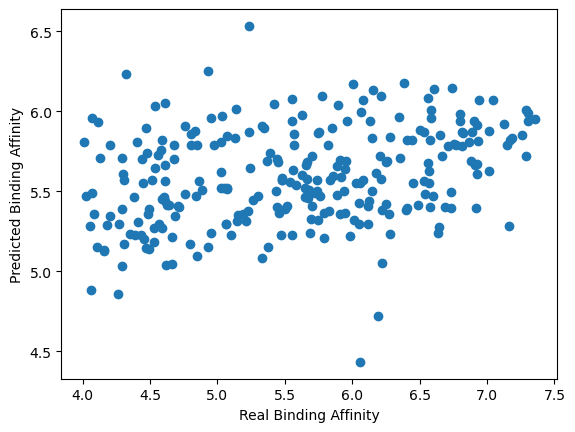

In [123]:
# Doing linear regression
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

# Plot outputs
plt.scatter(y_test,y_pred)
plt.xlabel('Real Binding Affinity')
plt.ylabel('Predicted Binding Affinity')


In [ ]:
# Now let's use SVR for regression!
from sklearn.svm import SVR
svr = SVR()
